## Two site Hubbard Model

In [1]:
# the version of Yao is 0.4.1 in this notebook
using Yao

┌ Info: Recompiling stale cache file /home/leo/.julia/compiled/v1.1/Yao/TDiQQ.ji for Yao [5872b779-8223-5990-8dd0-5abbb0748c8c]
└ @ Base loading.jl:1184


In [2]:
function hubbard_hamiltonain(t::Real, U::Real)
    0.5t * (kron(X, Z, X, I2) +
        kron(Y, Z, Y, I2) + 
        kron(I2, X, Z, X) +
        kron(I2, Y, Z, Y)) +
    0.25U * (kron(Z, Z, I2, I2) +
        kron(I2, I2, Z, Z))
end

hubbard_hamiltonain (generic function with 1 method)

In [3]:
hami = hubbard_hamiltonain(1, 1)

nqubits: 4, datatype: Complex{Float64}
sum
├─ [scale: 0.5] sum
│     ├─ kron
│     │  ├─ 1=>X gate
│     │  ├─ 2=>Z gate
│     │  ├─ 3=>X gate
│     │  └─ 4=>I2 gate
│     ├─ kron
│     │  ├─ 1=>Y gate
│     │  ├─ 2=>Z gate
│     │  ├─ 3=>Y gate
│     │  └─ 4=>I2 gate
│     ├─ kron
│     │  ├─ 1=>I2 gate
│     │  ├─ 2=>X gate
│     │  ├─ 3=>Z gate
│     │  └─ 4=>X gate
│     └─ kron
│        ├─ 1=>I2 gate
│        ├─ 2=>Y gate
│        ├─ 3=>Z gate
│        └─ 4=>Y gate
└─ [scale: 0.25] sum
      ├─ kron
      │  ├─ 1=>Z gate
      │  ├─ 2=>Z gate
      │  ├─ 3=>I2 gate
      │  └─ 4=>I2 gate
      └─ kron
         ├─ 1=>I2 gate
         ├─ 2=>I2 gate
         ├─ 3=>Z gate
         └─ 4=>Z gate


In [4]:
ishermitian(hami)

true

In [5]:
Hmat = mat(hami)

16×16 SparseArrays.SparseMatrixCSC{Complex{Float64},Int64} with 24 stored entries:
  [1 ,  1]  =  0.5+0.0im
  [5 ,  2]  =  1.0+0.0im
  [9 ,  3]  =  1.0+0.0im
  [4 ,  4]  =  0.5+0.0im
  [7 ,  4]  =  -1.0+0.0im
  [10,  4]  =  1.0+0.0im
  [2 ,  5]  =  1.0+0.0im
  [6 ,  6]  =  -0.5+0.0im
  [4 ,  7]  =  -1.0+0.0im
  [7 ,  7]  =  -0.5+0.0im
  [13,  7]  =  -1.0+0.0im
  [14,  8]  =  -1.0+0.0im
  [3 ,  9]  =  1.0+0.0im
  [4 , 10]  =  1.0+0.0im
  [10, 10]  =  -0.5+0.0im
  [13, 10]  =  1.0+0.0im
  [11, 11]  =  -0.5+0.0im
  [15, 12]  =  -1.0+0.0im
  [7 , 13]  =  -1.0+0.0im
  [10, 13]  =  1.0+0.0im
  [13, 13]  =  0.5+0.0im
  [8 , 14]  =  -1.0+0.0im
  [12, 15]  =  -1.0+0.0im
  [16, 16]  =  0.5+0.0im

In [6]:
using KrylovKit

In [7]:
?eigsolve

search: eigsolve geneigsolve



```
eigsolve(A::AbstractMatrix, [howmany = 1, which = :LM, T = eltype(A)]; kwargs...)
eigsolve(f, n::Int, [howmany = 1, which = :LM, T = Float64]; kwargs...)
eigsolve(f, x₀, [howmany = 1, which = :LM]; kwargs...)
eigsolve(f, x₀, howmany, which, algorithm)
```

Compute at least `howmany` eigenvalues from the linear map encoded in the matrix `A` or by the function `f`. Return eigenvalues, eigenvectors and a `ConvergenceInfo` structure.

### Arguments:

The linear map can be an `AbstractMatrix` (dense or sparse) or a general function or callable object. If an `AbstractMatrix` is used, a starting vector `x₀` does not need to be provided, it is then chosen as `rand(T, size(A,1))`. If the linear map is encoded more generally as a a callable function or method, the best approach is to provide an explicit starting guess `x₀`. Note that `x₀` does not need to be of type `AbstractVector`, any type that behaves as a vector and supports the required methods (see KrylovKit docs) is accepted. If instead of `x₀` an integer `n` is specified, it is assumed that `x₀` is a regular vector and it is initialized to `rand(T,n)`, where the default value of `T` is `Float64`, unless specified differently.

The next arguments are optional, but should typically be specified. `howmany` specifies how many eigenvalues should be computed; `which` specifies which eigenvalues should be targetted. Valid specifications of `which` are given by

  * `:LM`: eigenvalues of largest magnitude
  * `:LR`: eigenvalues with largest (most positive) real part
  * `:SR`: eigenvalues with smallest (most negative) real part
  * `:LI`: eigenvalues with largest (most positive) imaginary part, only if `T <: Complex`
  * `:SI`: eigenvalues with smallest (most negative) imaginary part, only if `T <: Complex`
  * [`EigSorter(f; rev = false)`](@ref): eigenvalues `λ` that appear first (or last if   `rev == true`) when sorted by `f(λ)`

!!! note "Note about selecting `which` eigenvalues"
    Krylov methods work well for extremal eigenvalues, i.e. eigenvalues on the periphery of the spectrum of the linear map. All of they valid `Symbol`s for `which` have this property, but could also be specified usign `EigSorter`, e.g. `:LM` is equivalent to `Eigsorter(abs; rev = true)`. Note that smallest magnitude sorting is obtained using e.g. `EigSorter(abs; rev = false)`, but since no (shift-and)-invert is used, this will only be successfull if you somehow know that eigenvalues close to zero are also close to the periphery of the spectrum.


The argument `T` acts as a hint in which `Number` type the computation should be performed, but is not restrictive. If the linear map automatically produces complex values, complex arithmetic will be used even though `T<:Real` was specified. However, if the linear map and initial guess are real, approximate eigenvalues will be searched for using a partial Schur factorization, which implies that complex conjugate eigenvalues come in pairs and cannot be split. It is then illegal to choose `which` in a way that would treat `λ` and `conj(λ)` differently, i.e. `:LI` and `:SI` are invalid, as well as any `EigSorter` that would lead to `by(λ) != by(conj(λ))`.

### Return values:

The return value is always of the form `vals, vecs, info = eigsolve(...)` with

  * `vals`: a `Vector` containing the eigenvalues, of length at least `howmany`, but could   be longer if more eigenvalues were converged at the same cost. Eigenvalues will be real   if [`Lanczos`](@ref) was used and complex if [`Arnoldi`](@ref) was used (see below).
  * `vecs`: a `Vector` of corresponding eigenvectors, of the same length as `vals`. Note   that eigenvectors are not returned as a matrix, as the linear map could act on any   custom Julia type with vector like behavior, i.e. the elements of the list `vecs` are   objects that are typically similar to the starting guess `x₀`, up to a possibly   different `eltype`. In particular  for a general matrix (i.e. with `Arnoldi`) the   eigenvectors are generally complex and are therefore always returned in a complex   number format. When the linear map is a simple `AbstractMatrix`, `vecs` will be   `Vector{Vector{<:Number}}`.
  * `info`: an object of type [`ConvergenceInfo`], which has the following fields

      * `info.converged::Int`: indicates how many eigenvalues and eigenvectors were actually   converged to the specified tolerance `tol` (see below under keyword arguments)
      * `info.residual::Vector`: a list of the same length as `vals` containing the   residuals `info.residual[i] = f(vecs[i]) - vals[i] * vecs[i]`
      * `info.normres::Vector{<:Real}`: list of the same length as `vals` containing the   norm of the residual `info.normres[i] = norm(info.residual[i])`
      * `info.numops::Int`: number of times the linear map was applied, i.e. number of times   `f` was called, or a vector was multiplied with `A`
      * `info.numiter::Int`: number of times the Krylov subspace was restarted (see below)

!!! warning "Check for convergence"
    No warning is printed if not all requested eigenvalues were converged, so always check if `info.converged >= howmany`.


### Keyword arguments:

Keyword arguments and their default values are given by:

  * `verbosity::Int = 0`: verbosity level, i.e. 0 (no messages), 1 (single message   at the end), 2 (information after every iteration), 3 (information per Krylov step)
  * `tol::Real`: the requested accuracy (corresponding to the 2-norm of the residual for   Schur vectors, not the eigenvectors). If you work in e.g. single precision (`Float32`),   you should definitely change the default value.
  * `krylovdim::Integer`: the maximum dimension of the Krylov subspace that will be   constructed. Note that the dimension of the vector space is not known or checked, e.g.   `x₀` should not necessarily support the `Base.length` function. If you know the actual   problem dimension is smaller than the default value, it is useful to reduce the value of   `krylovdim`, though in principle this should be detected.
  * `maxiter::Integer`: the number of times the Krylov subspace can be rebuilt; see below   for further details on the algorithms.
  * `orth::Orthogonalizer`: the orthogonalization method to be used, see   [`Orthogonalizer`](@ref)
  * `issymmetric::Bool`: if the linear map is symmetric, only meaningful if `T<:Real`
  * `ishermitian::Bool`: if the linear map is hermitian

The default values are given by `tol = KrylovDefaults.tol`, `krylovdim = KrylovDefaults.krylovdim`, `maxiter = KrylovDefaults.maxiter`, `orth = KrylovDefaults.orth`; see [`KrylovDefaults`](@ref) for details.

The default value for the last two parameters depends on the method. If an `AbstractMatrix` is used, `issymmetric` and `ishermitian` are checked for that matrix, ortherwise the default values are `issymmetric = false` and `ishermitian = T <: Real && issymmetric`. When values for the keyword arguments are provided, no checks will be performed even in the matrix case.

### Algorithm

The last method, without default values and keyword arguments, is the one that is finally called, and can also be used directly. Here, one specifies the algorithm explicitly as either [`Lanczos`](@ref), for real symmetric or complex hermitian problems, or [`Arnoldi`](@ref), for general problems. Note that these names refer to the process for building the Krylov subspace, but the actual algorithm is an implementation of the Krylov-Schur algorithm, which can dynamically shrink and grow the Krylov subspace, i.e. the restarts are so-called thick restarts where a part of the current Krylov subspace is kept.

!!! note "Note about convergence"
    In case of a general problem, where the `Arnoldi` method is used, convergence of an eigenvalue is not based on the norm of the residual `norm(f(vecs[i]) - vals[i]*vecs[i])` for the eigenvector but rather on the norm of the residual for the corresponding Schur vectors.

    See also [`schursolve`](@ref) if you want to use the partial Schur decomposition directly, or if you are not interested in computing the eigenvectors, and want to work in real arithmetic all the way true (if the linear map and starting guess are real).



In [8]:
x0 = randn(ComplexF64, size(Hmat, 2)) |> normalize!
E, V = eigsolve(Hmat, x0, 1, :SR)
EG = E[1]

-2.061552812808826

## Differential programming to obtain the ground state

#### Python packages
* PyTorch
* Tensorflow

#### Julia packages
* Zygote.jl
* Flux.jl
* KNet.jl

You can find them on github.

In [9]:
using Zygote: gradient
using Zygote

In [10]:
using LinearAlgebra

E, V = eigen(Hmat |> Matrix)
@show E[1]

E[1] = -2.0615528128088267


-2.0615528128088267

In [11]:
f(x) = real(x'*Hmat*x/(x'*x))[]

x = randn(ComplexF64, size(Hmat, 2))
α = 0.5

for i = 1:100
    g = f'(x)
    x -= α .* g
    println("Energy is $(f(x))")
end

Energy is -0.30728352179163376
Energy is -0.610091512054176
Energy is -0.8751848119517485
Energy is -1.0966632149588948
Energy is -1.2767727874355648
Energy is -1.4218327687380814
Energy is -1.5388811876577468
Energy is -1.6339851944354429
Energy is -1.7118145551940673
Energy is -1.7758161940429658
Energy is -1.8285464157178082
Energy is -1.8719637665797653
Energy is -1.9076316643443505
Energy is -1.9368413244245652
Energy is -1.9606810827087684
Energy is -1.9800752265217898
Energy is -1.9958077724162986
Energy is -2.0085397966479555
Energy is -2.018824337873852
Energy is -2.0271203224328485
Energy is -2.0338057590751943
Energy is -2.0391900219465646
Energy is -2.0435249850368615
Energy is -2.047014856186396
Energy is -2.049824669525995
Energy is -2.0520874856967666
Energy is -2.0539104077097208
Energy is -2.0553795499796648
Energy is -2.0565641065563165
Energy is -2.0575196595213416
Energy is -2.0582908559601445
Energy is -2.058913566052854
Energy is -2.0594166183129285
Energy is -2.0

In [12]:
using Random
using Plots
Random.seed!(2);

# The landscape of a quantum circuit

Here, $U_{1:k}$ and $U_{k+1:N}$ are two random circuits. $U_k(\eta)$ is a rotation gate defined as $U_k(\eta) = e^{-i\Xi \eta/2}$ with $\Xi^2 = 1$.

> Nakanishi, Ken M., Keisuke Fujii, and Synge Todo. "Sequential minimal optimization for quantum-classical hybrid algorithms." arXiv preprint arXiv:1903.12166 (2019).

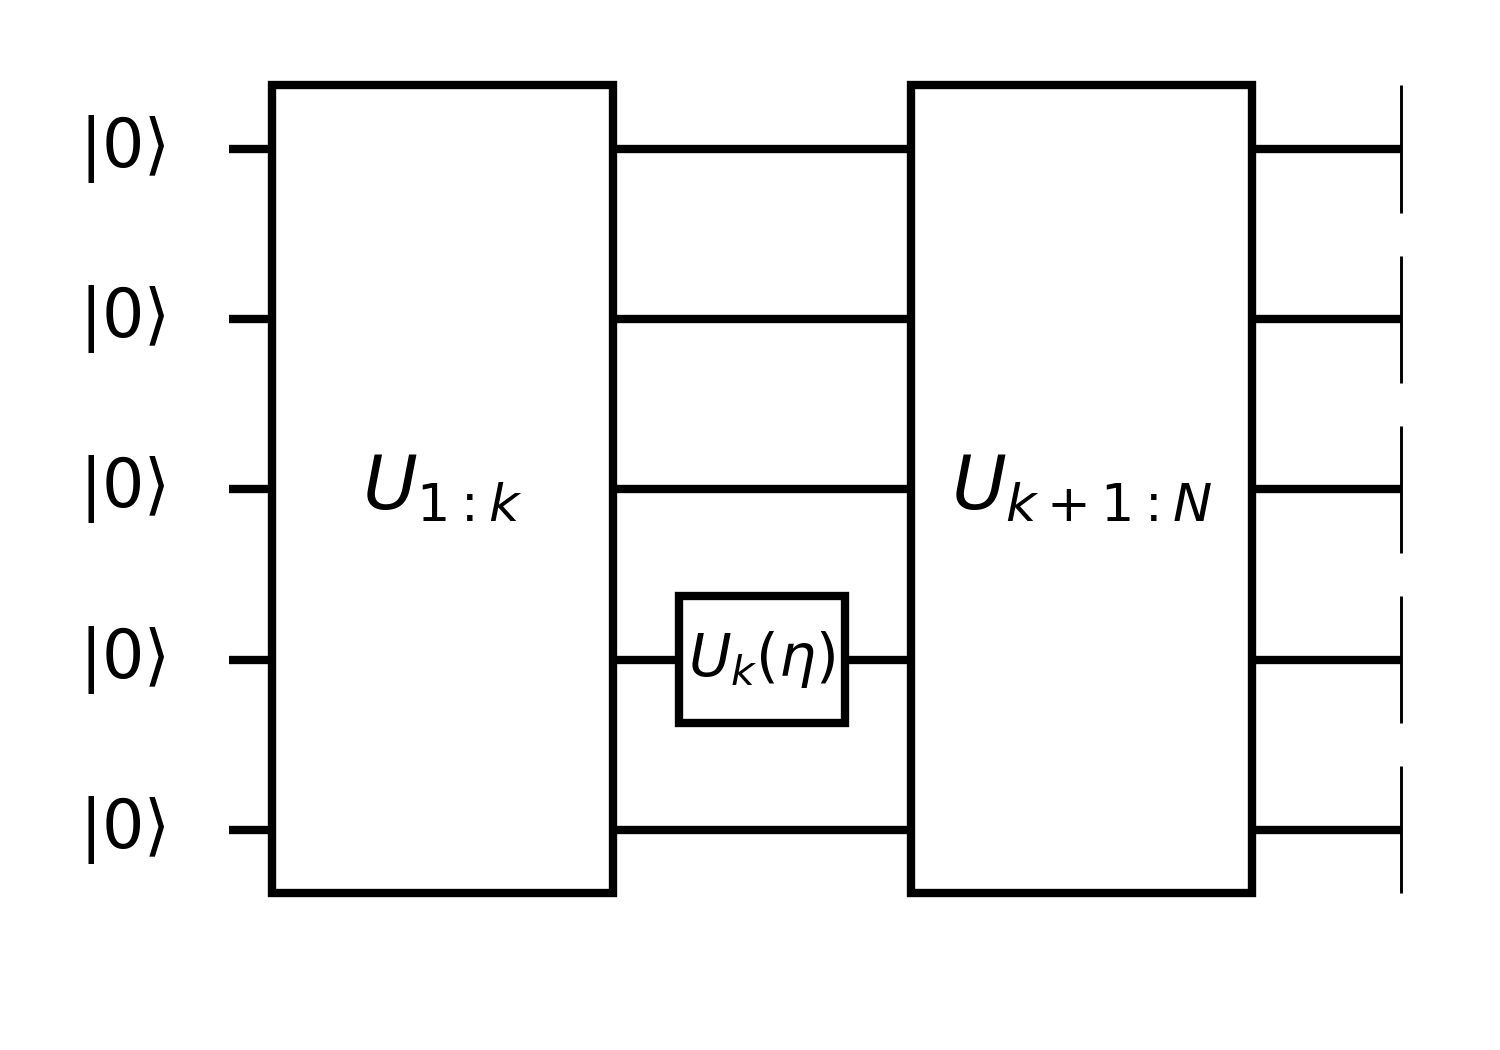

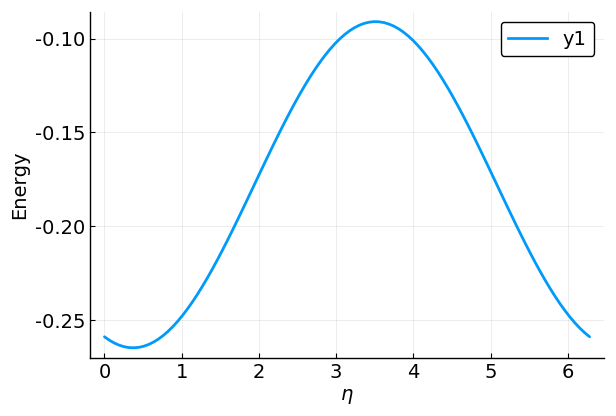

In [13]:
function scan_params(Uj, observable, nparam::Int)
    x = LinRange(0, 2π, nparam)
    y = zeros(nparam)
    for (i,x) in enumerate(x)
        dispatch!(Uj, x)
        y[i] = expect(observable, zero_state(N) |> c) |> real
    end
    x, y
end

N = 5

V1j = rand_unitary(1<<N) |> matblock
V2j = rand_unitary(1<<N) |> matblock

Uj = put(N, 4=>Rx(0.0))
c = chain(N, [V1j, Uj, V2j])

observable = put(N, 4=>Z)
xs, ys = scan_params(Uj, observable, 100)

# see a sine curve
pyplot()
using LaTeXStrings
fnt = Plots.font("Helvetica", 10.0)
default(titlefont=fnt, guidefont=fnt, tickfont=fnt, legendfont=fnt)
ax = plot(xs, ys, lw=2, xlabel=L"\eta", ylabel="Energy")

In [20]:
function train!(circuit, hami; maxiter=200, α=0.3)
    nbit = nqubits(circuit)
    rots = collect_blocks(RotationGate, circuit)
    loss_history = Float64[]
    for i in 0:maxiter
        for (j,r) in enumerate(rots)
            dispatch!(+, r, π/2)
            E₊ = expect(hami, zero_state(nbit) |> circuit) |> real
            dispatch!(-, r, π)
            E₋ = expect(hami, zero_state(nbit) |> circuit) |> real
            dispatch!(+, r, π/2)
            g = 0.5(E₊ - E₋)
            dispatch!(-, r, α*g)
        end
        push!(loss_history, expect(hami, zero_state(nbit) |> circuit) |> real)
        
        if i%10 == 0
            println("Iter $i, E = $(loss_history[end])")
        end
    end
    loss_history, circuit
end

train! (generic function with 1 method)

In [21]:
using QuAlgorithmZoo: random_diff_circuit
circuit = random_diff_circuit(4, 2, [1=>2, 2=>3, 3=>4, 4=>1])

nqubits: 4, datatype: Complex{Float64}
chain
├─ chain
│  ├─ chain
│  │  ├─ put on (1)
│  │  │  └─ rot(X gate, 0.0)
│  │  └─ put on (1)
│  │     └─ rot(Z gate, 0.0)
│  ├─ chain
│  │  ├─ put on (2)
│  │  │  └─ rot(X gate, 0.0)
│  │  └─ put on (2)
│  │     └─ rot(Z gate, 0.0)
│  ├─ chain
│  │  ├─ put on (3)
│  │  │  └─ rot(X gate, 0.0)
│  │  └─ put on (3)
│  │     └─ rot(Z gate, 0.0)
│  └─ chain
│     ├─ put on (4)
│     │  └─ rot(X gate, 0.0)
│     └─ put on (4)
│        └─ rot(Z gate, 0.0)
├─ chain
│  ├─ control(1)
│  │  └─ (2,) X gate
│  ├─ control(2)
│  │  └─ (3,) X gate
│  ├─ control(3)
│  │  └─ (4,) X gate
│  └─ control(4)
│     └─ (1,) X gate
├─ chain
│  ├─ chain
│  │  ├─ put on (1)
│  │  │  └─ rot(Z gate, 0.0)
│  │  ├─ put on (1)
│  │  │  └─ rot(X gate, 0.0)
│  │  └─ put on (1)
│  │     └─ rot(Z gate, 0.0)
│  ├─ chain
│  │  ├─ put on (2)
│  │  │  └─ rot(Z gate, 0.0)
│  │  ├─ put on (2)
│  │  │  └─ rot(X gate, 0.0)
│  │  └─ put on (2)
│  │     └─ rot(Z gate, 0.0)
│  ├─ chain
│  │  

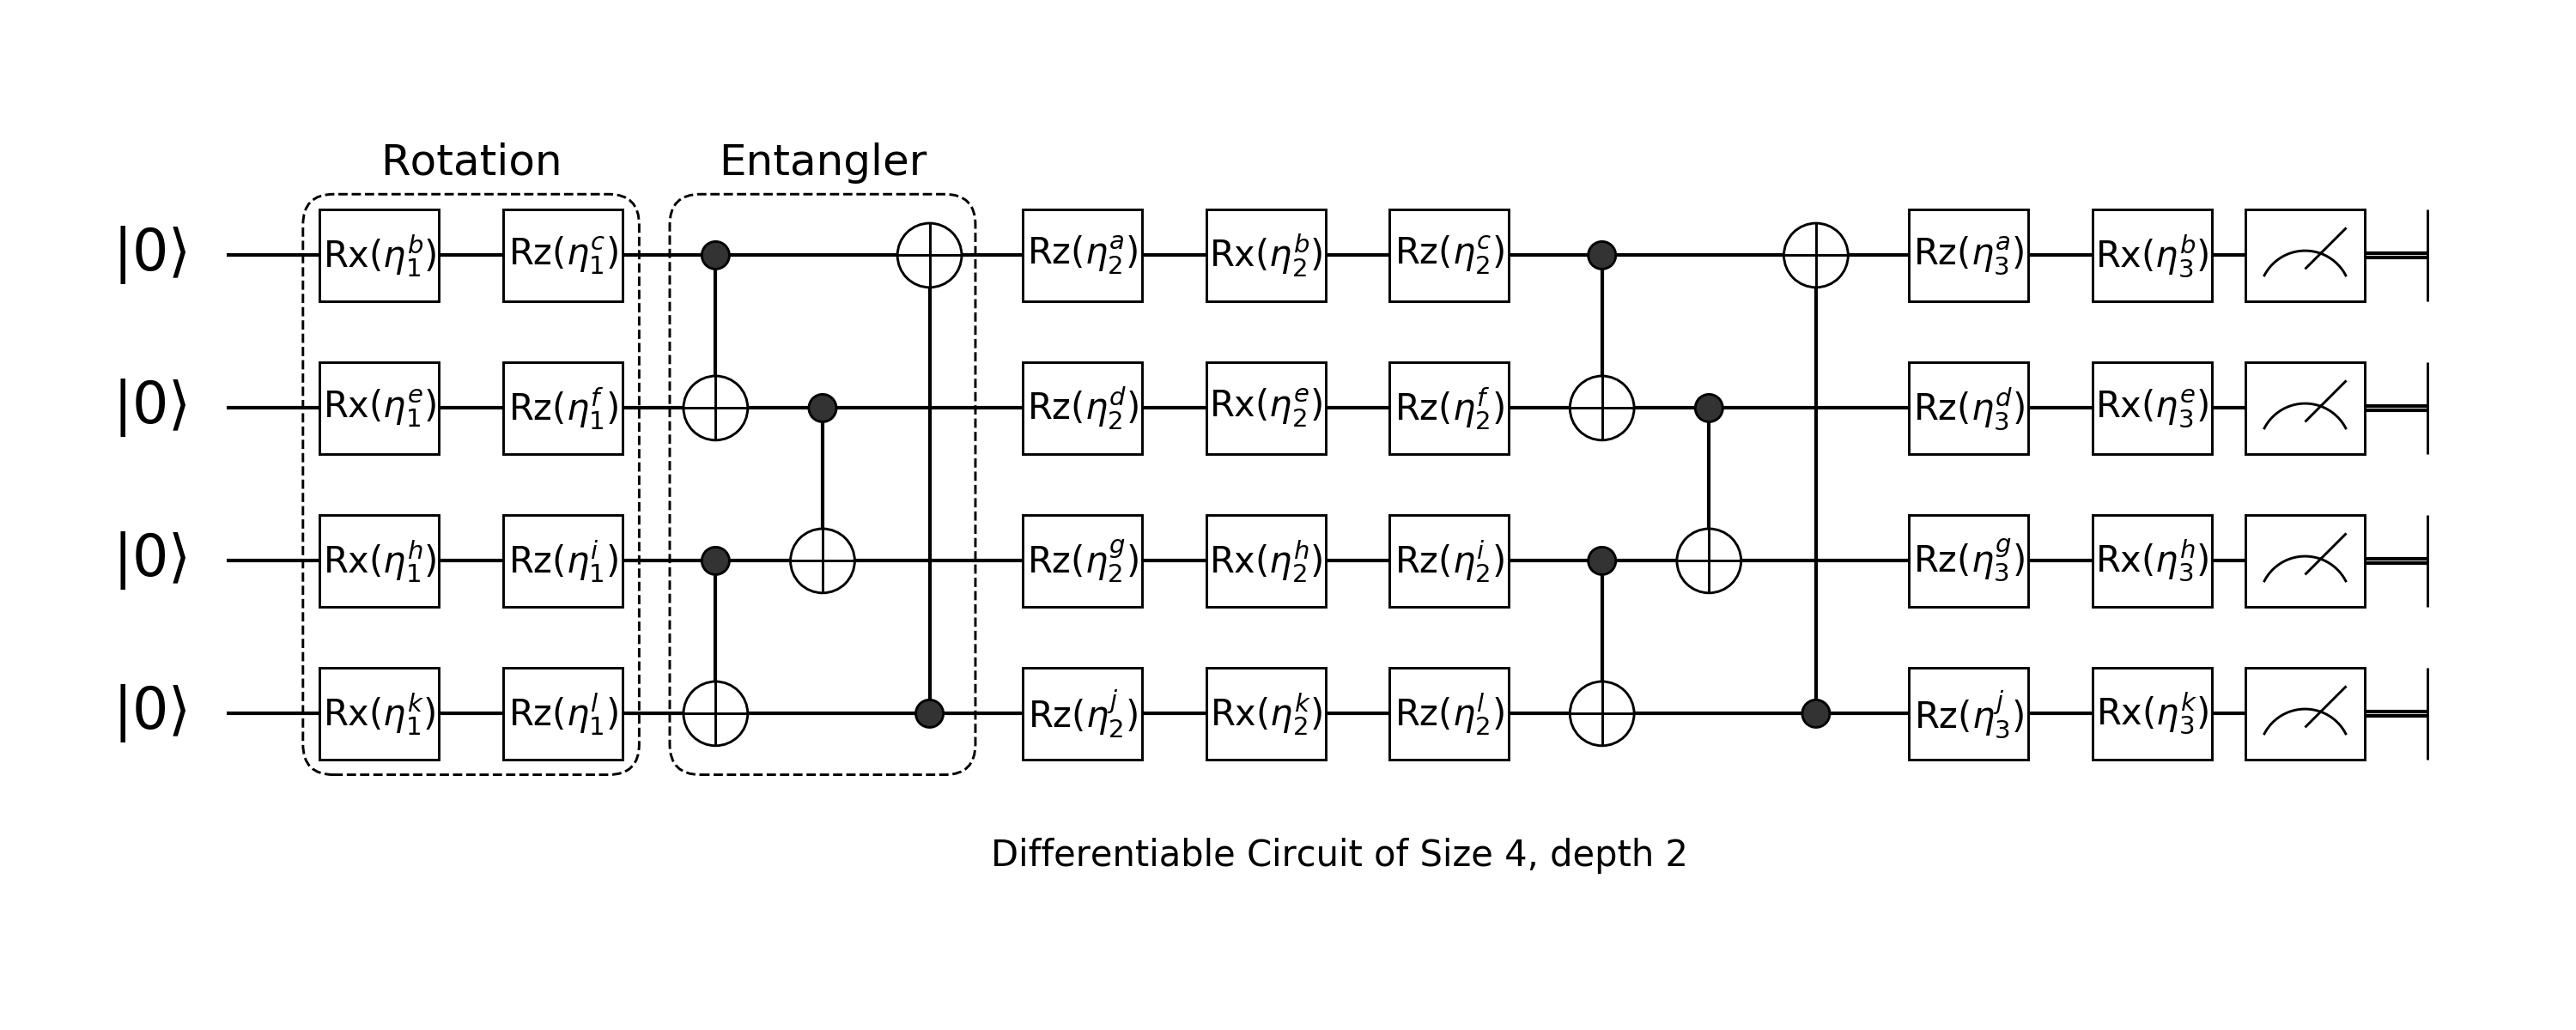

In [22]:
expect(hami, rand_state(4))

0.3529117969808263 - 2.0816681711721685e-17im

In [26]:
train!(dispatch!(circuit, :random), hami; maxiter=1000)

Iter 0, E = 0.04295796022918272
Iter 10, E = -1.3903629767655226
Iter 20, E = -1.9569691316289215
Iter 30, E = -2.0450624157045336
Iter 40, E = -2.0573642814312967
Iter 50, E = -2.059767560374465
Iter 60, E = -2.060515865842985
Iter 70, E = -2.060869399810746
Iter 80, E = -2.061078641727261
Iter 90, E = -2.0612151855275833
Iter 100, E = -2.0613085465569547
Iter 110, E = -2.0613741433561885
Iter 120, E = -2.061421083737497
Iter 130, E = -2.0614551200936733
Iter 140, E = -2.0614800433210516
Iter 150, E = -2.0614984289938914
Iter 160, E = -2.0615120682043924
Iter 170, E = -2.061522229425718
Iter 180, E = -2.0615298240107145
Iter 190, E = -2.061535514178772
Iter 200, E = -2.061539785396926
Iter 210, E = -2.061542996014691
Iter 220, E = -2.0615454119613643
Iter 230, E = -2.061547231392132
Iter 240, E = -2.061548602425389
Iter 250, E = -2.0615496360437726
Iter 260, E = -2.061550415556917
Iter 270, E = -2.0615510035886206
Iter 280, E = -2.061551447262872
Iter 290, E = -2.0615517820685425
Iter

([0.042958, -0.136192, -0.322098, -0.502111, -0.668813, -0.819189, -0.953367, -1.07408, -1.18526, -1.29018  …  -2.06155, -2.06155, -2.06155, -2.06155, -2.06155, -2.06155, -2.06155, -2.06155, -2.06155, -2.06155], nqubits: 4, datatype: Complex{Float64}
chain
├─ chain
│  ├─ chain
│  │  ├─ put on (1)
│  │  │  └─ rot(X gate, 2.1891672187801526e-7)
│  │  └─ put on (1)
│  │     └─ rot(Z gate, 0.7204451926105048)
│  ├─ chain
│  │  ├─ put on (2)
│  │  │  └─ rot(X gate, 0.0)
│  │  └─ put on (2)
│  │     └─ rot(Z gate, 0.48757482007577657)
│  ├─ chain
│  │  ├─ put on (3)
│  │  │  └─ rot(X gate, 1.3258176636680234)
│  │  └─ put on (3)
│  │     └─ rot(Z gate, 0.478912077650635)
│  └─ chain
│     ├─ put on (4)
│     │  └─ rot(X gate, -5.10702591327572e-16)
│     └─ put on (4)
│        └─ rot(Z gate, -0.05578187143382296)
├─ chain
│  ├─ control(1)
│  │  └─ (2,) X gate
│  ├─ control(2)
│  │  └─ (3,) X gate
│  ├─ control(3)
│  │  └─ (4,) X gate
│  └─ control(4)
│     └─ (1,) X gate
├─ chain
│  ├─ chain

In [37]:
zero_state(4) |> circuit

ArrayReg{1, Complex{Float64}, Array...}
    active qubits: 4/4

In [43]:
# pick two parameters
rots = collect_blocks(RotationGate, circuit);
rand(rots, 2)

2-element Array{RotationGate,1}:
 rot(Z gate, 0.30762860908294737) 
 rot(Z gate, -0.05578187143382296)

In [49]:
function K_overlap(circuit::AbstractBlock, rots, xs, ψ0::AbstractRegister)
    nbit = nqubits(circuit)
    dispatch!.(rots, xs)
    ψ = zero_state(nbit) |> circuit
    real(ψ' * ψ0)
end

K_overlap (generic function with 2 methods)

In [51]:
y(xs) = Int(norm(xs) < 1)

y (generic function with 1 method)

In [54]:
y([0.9,0.5])

0

In [50]:
zero_state(4) |> circuit

ArrayReg{1, Complex{Float64}, Array...}
    active qubits: 4/4

## Gradient Vanishing Problem

In [28]:
using Statistics

function rand_gradient(N::Int, hami)
    V1j = rand_unitary(1<<N) |> matblock
    V2j = rand_unitary(1<<N) |> matblock

    Uj = put(N, 1=>Rx(0.0))
    c = chain(N, [V1j, Uj, V2j])
    
    η = rand()*2π
    dispatch!(Uj, η+π/2)
    y₊ = expect(hami, zero_state(N) |> c) |> real

    dispatch!(Uj, η-π/2)
    y₋ = expect(hami, zero_state(N) |> c) |> real
    (y₊ - y₋)/2
end

maxN = 9
grad_vars = [mean([abs(rand_gradient(N)) for i=1:100]) for N=1:maxN]

UndefVarError: UndefVarError: yscale not defined

┌ Warning: scale log is unsupported with Plots.PyPlotBackend().  Choose from: Symbol[:identity, :ln, :log2, :log10]
└ @ Plots /home/leo/.julia/packages/Plots/47Tik/src/args.jl:1170


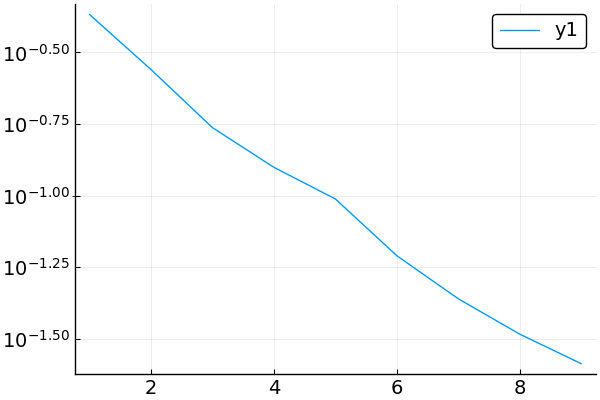

In [35]:
# see a sine curve
ax = plot(1:maxN, grad_vars, yscale=:log)

## A Simple Example: QFT Algorithm
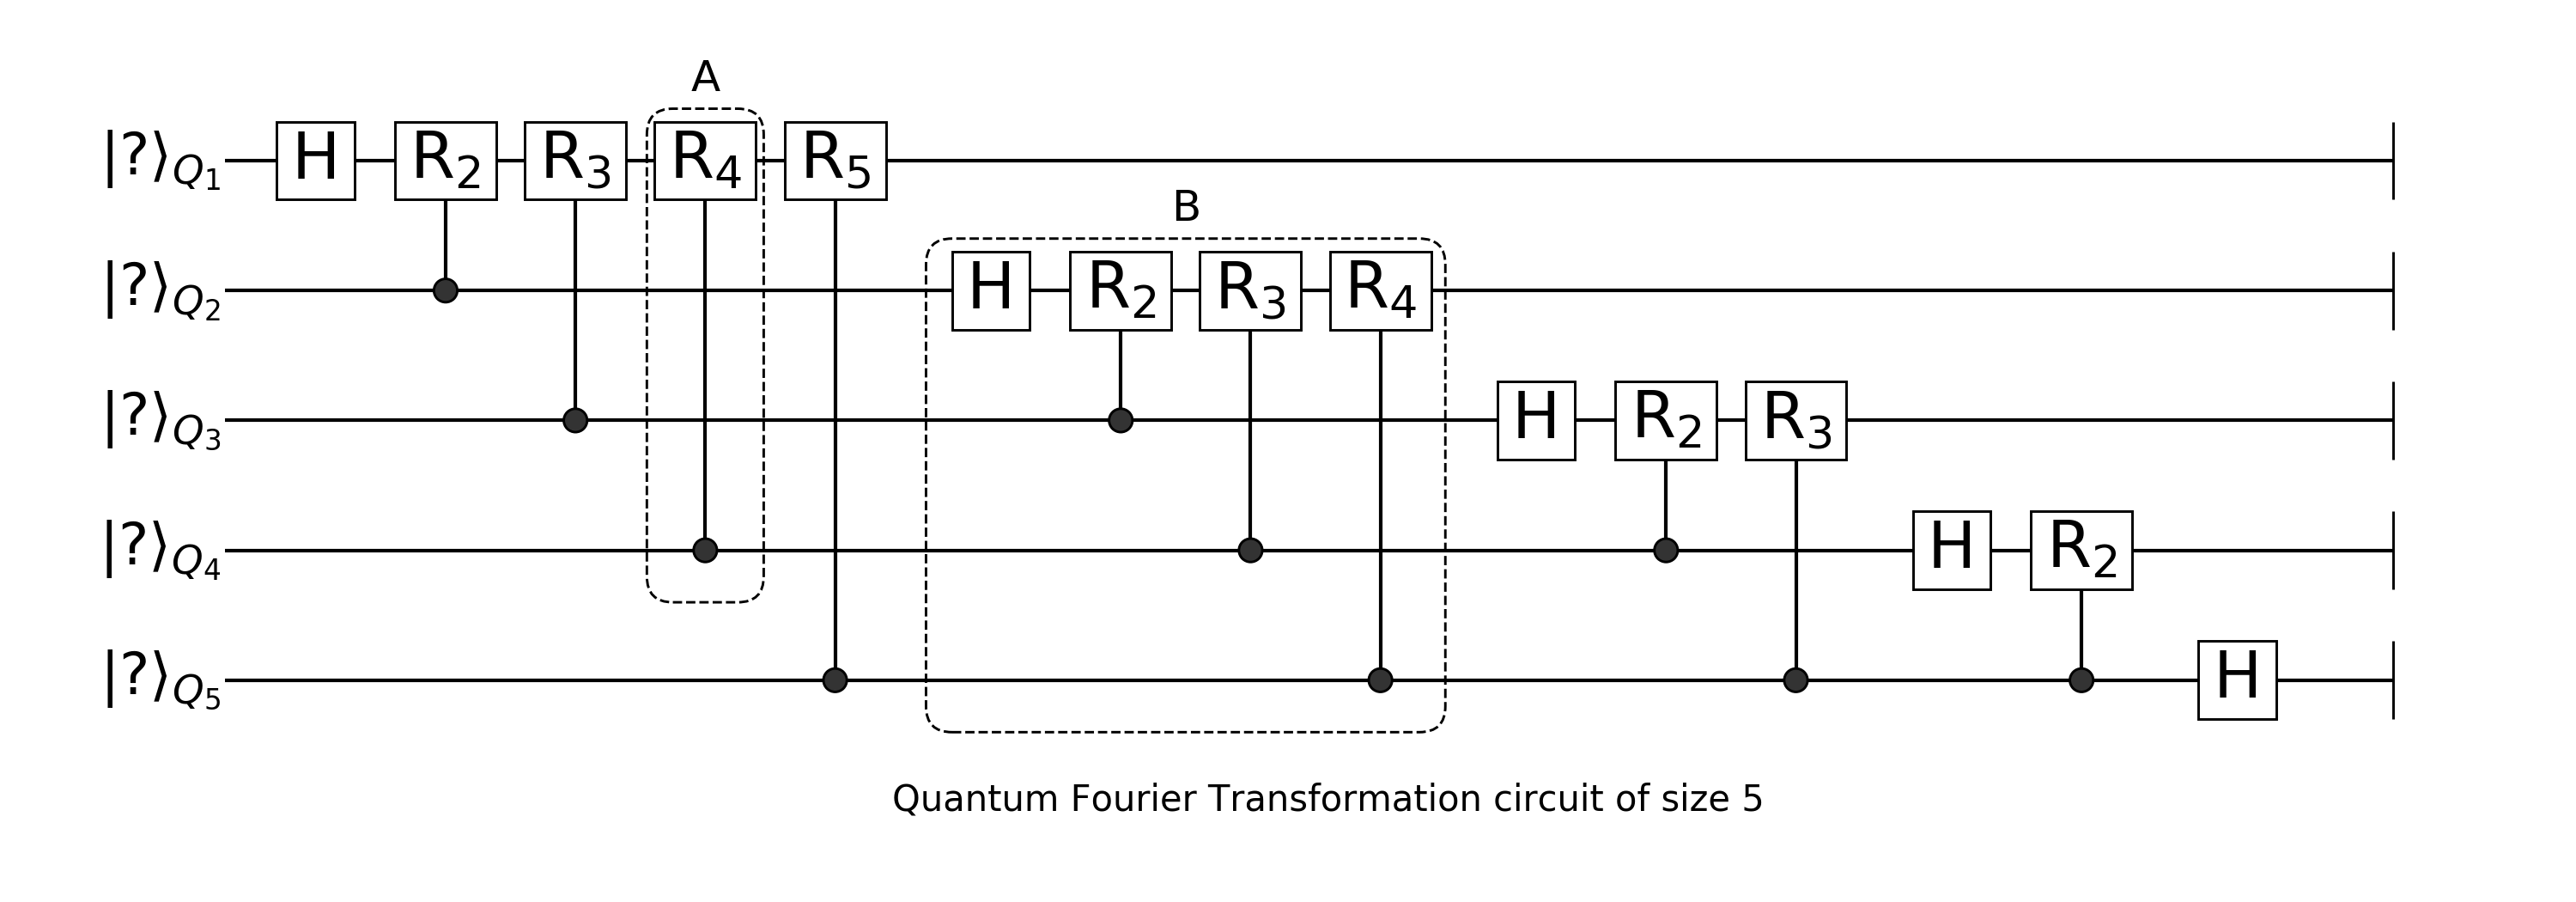

In [7]:
CRk(i::Int, j::Int, k::Int) = control([i, ], j=>shift(2π/(1<<k)))
CRot(n::Int, i::Int) = chain(n, i==j ? kron(i=>H) : CRk(j, i, j-i+1) for j = i:n)
QFTCircuit(n::Int) = chain(n, CRot(n, i) for i = 1:n)

qft = QFTCircuit(5)

nqubits: 5, datatype: Complex{Float64}
chain
├─ chain
│  ├─ kron
│  │  └─ 1=>H gate
│  ├─ control(2)
│  │  └─ (1,) shift(1.5707963267948966)
│  ├─ control(3)
│  │  └─ (1,) shift(0.7853981633974483)
│  ├─ control(4)
│  │  └─ (1,) shift(0.39269908169872414)
│  └─ control(5)
│     └─ (1,) shift(0.19634954084936207)
├─ chain
│  ├─ kron
│  │  └─ 2=>H gate
│  ├─ control(3)
│  │  └─ (2,) shift(1.5707963267948966)
│  ├─ control(4)
│  │  └─ (2,) shift(0.7853981633974483)
│  └─ control(5)
│     └─ (2,) shift(0.39269908169872414)
├─ chain
│  ├─ kron
│  │  └─ 3=>H gate
│  ├─ control(4)
│  │  └─ (3,) shift(1.5707963267948966)
│  └─ control(5)
│     └─ (3,) shift(0.7853981633974483)
├─ chain
│  ├─ kron
│  │  └─ 4=>H gate
│  └─ control(5)
│     └─ (4,) shift(1.5707963267948966)
└─ chain
   └─ kron
      └─ 5=>H gate


In [8]:
iqft = qft'

nqubits: 5, datatype: Complex{Float64}
chain
├─ chain
│  └─ kron
│     └─ 5=>H gate
├─ chain
│  ├─ control(5)
│  │  └─ (4,) shift(-1.5707963267948966)
│  └─ kron
│     └─ 4=>H gate
├─ chain
│  ├─ control(5)
│  │  └─ (3,) shift(-0.7853981633974483)
│  ├─ control(4)
│  │  └─ (3,) shift(-1.5707963267948966)
│  └─ kron
│     └─ 3=>H gate
├─ chain
│  ├─ control(5)
│  │  └─ (2,) shift(-0.39269908169872414)
│  ├─ control(4)
│  │  └─ (2,) shift(-0.7853981633974483)
│  ├─ control(3)
│  │  └─ (2,) shift(-1.5707963267948966)
│  └─ kron
│     └─ 2=>H gate
└─ chain
   ├─ control(5)
   │  └─ (1,) shift(-0.19634954084936207)
   ├─ control(4)
   │  └─ (1,) shift(-0.39269908169872414)
   ├─ control(3)
   │  └─ (1,) shift(-0.7853981633974483)
   ├─ control(2)
   │  └─ (1,) shift(-1.5707963267948966)
   └─ kron
      └─ 1=>H gate


In [9]:
reg = rand_state(5)
copy(reg) |> qft |> iqft ≈ reg

true